# **Computer Vision**
## **Assignment I**

### Yash Maniya (B20CS033)

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import cv2

### **1. Harris Corner detection**

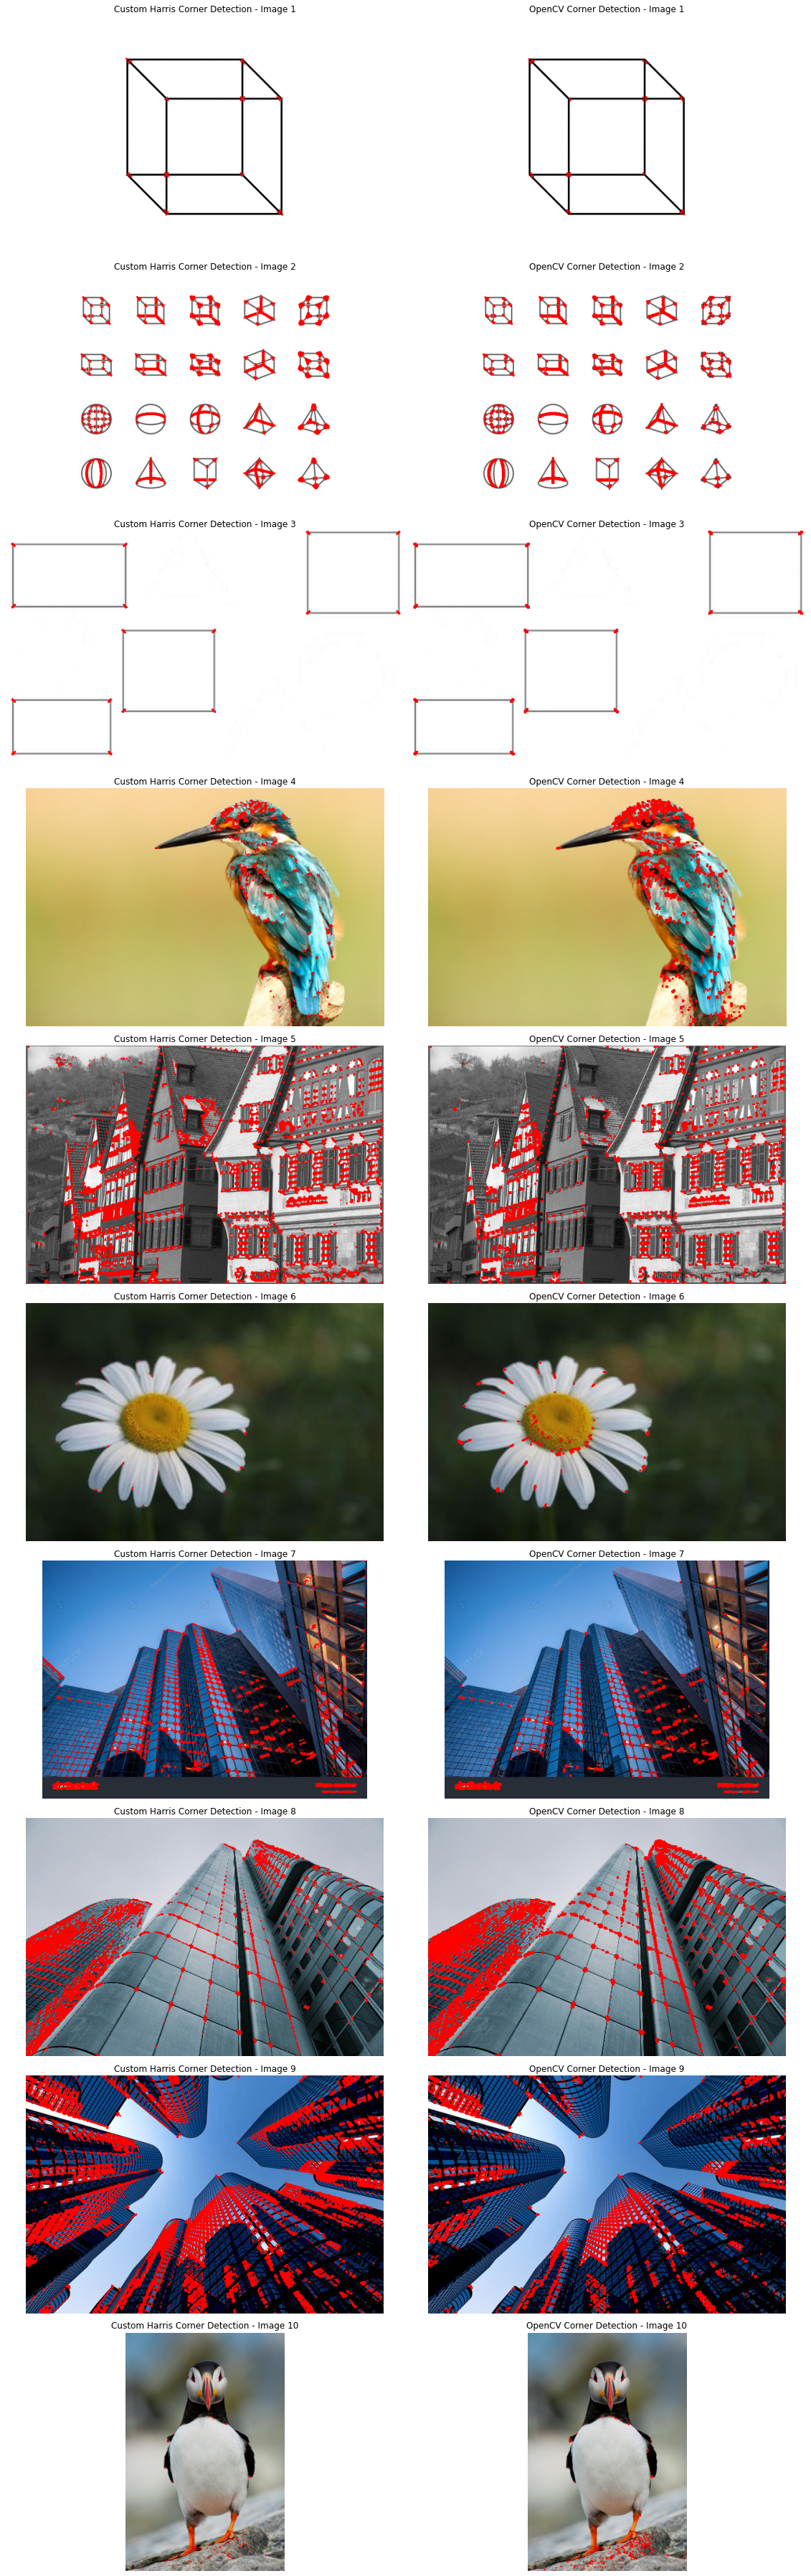

In [3]:
class HarrisCornerDetector():
    def __init__(self, directory, window_size=3, threshold=10000):
        self.directory = directory
        self.window_size = window_size
        self.threshold = threshold
        self.images = self.load_images()
    
    def load_images(self):
        images = []
        for filename in sorted(os.listdir(self.directory)):
            img = cv2.imread(os.path.join(self.directory, filename))
            height, width = img.shape[:2]
            new_width = [600, 400][not images]
            new_height = int(height * (new_width / width))
            img = cv2.resize(img, (new_width, new_height))
            images.append(img)
        return images

    def sobel(self, image, axis):
        kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) if axis == 'x' else np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        return convolve(image, kernel)

    def gaussian_blur(self, image, size):
        kernel = self.gaussian_kernel(size)
        return convolve(image, kernel)

    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g / g.sum()

    def harris_corner_detection(self, image):
        gray = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
        height, width = gray.shape

        Ix = self.sobel(gray, 'x')
        Iy = self.sobel(gray, 'y')

        Ixx = Ix ** 2
        Iyy = Iy ** 2
        Ixy = Ix * Iy

        Sxx = self.gaussian_blur(Ixx, self.window_size)
        Syy = self.gaussian_blur(Iyy, self.window_size)
        Sxy = self.gaussian_blur(Ixy, self.window_size)

        det = (Sxx * Syy) - (Sxy ** 2)
        trace = Sxx + Syy

        harris_response = det - 0.04 * (trace ** 2)

        corners = np.zeros_like(harris_response)
        corners[harris_response > self.threshold] = 255

        return corners

    def detect_corners(self):
        detected_corners = []
        for i, image in enumerate(self.images):
            corners = self.harris_corner_detection(image)
            detected_corners.append(corners)
        return detected_corners

    def detect_corners(self):
        detected_corners = []
        for i, image in enumerate(self.images):
            corners = self.harris_corner_detection(image)
            detected_corners.append(corners)
        return detected_corners

    def compare_with_opencv(self):
        opencv_detected_corners = []
        for i, image in enumerate(self.images):
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            window = max(3, self.window_size - 4)
            corners_opencv = cv2.cornerHarris(gray, window, 3, 0.1)
            corners_opencv = cv2.dilate(corners_opencv, None)
            opencv_detected_corners.append(corners_opencv)
        return opencv_detected_corners

    def plot_images(self, detected_corners, opencv_detected_corners):
        fig, axes = plt.subplots(nrows=len(self.images), ncols=2, figsize=(16, 50))

        for i, (image, corners, opencv_corners) in enumerate(zip(self.images, detected_corners, opencv_detected_corners)):
            image_with_corners = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_with_corners[corners != 0] = [255, 0, 0]
            axes[i, 0].imshow(image_with_corners, extent=[0, 20*image.shape[1], 20*image.shape[0], 0])
            axes[i, 0].set_title(f'Custom Harris Corner Detection - Image {i+1}')

            image_with_opencv_corners = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_with_opencv_corners[opencv_corners > 0.01 * opencv_corners.max()] = [255, 0, 0]
            axes[i, 1].imshow(image_with_opencv_corners, extent=[0, 20*image.shape[1], 20*image.shape[0], 0])
            axes[i, 1].set_title(f'OpenCV Corner Detection - Image {i+1}')

            for ax in axes[i]:
                ax.axis('off')

        plt.tight_layout()
        plt.show()

detector = HarrisCornerDetector('./Question 1/', window_size=7, threshold=100000000)
detected_corners = detector.detect_corners()
opencv_detected_corners = detector.compare_with_opencv()
detector.plot_images(detected_corners, opencv_detected_corners)


### **2. Stereo 3D Reconstruction**

C:\Users\YASH MANIYA\AppData\Local\Temp\ipykernel_1768\1587261770.py:22: RuntimeWarning: divide by zero encountered in divide
  depth_map = baseline / disparity
C:\Users\YASH MANIYA\AppData\Local\Temp\ipykernel_1768\1587261770.py:31: RuntimeWarning: divide by zero encountered in divide
  Z = baseline / disparity


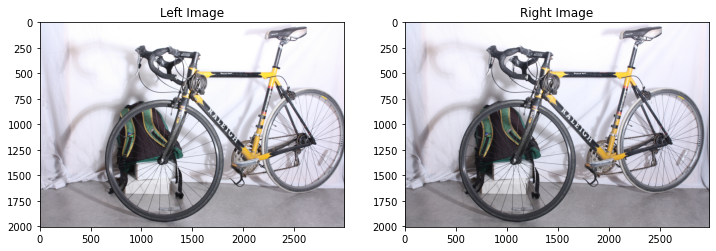

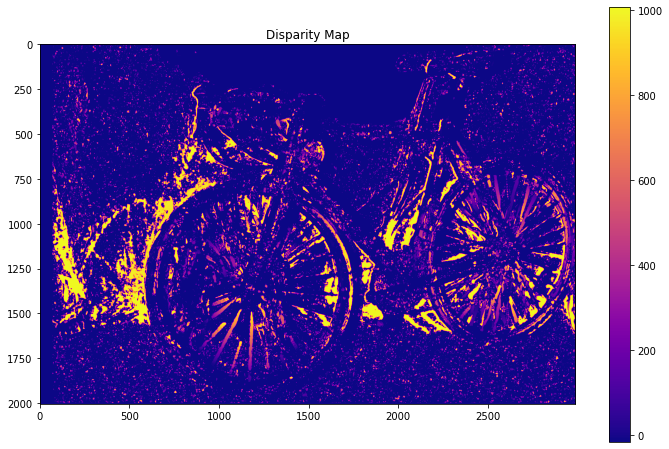

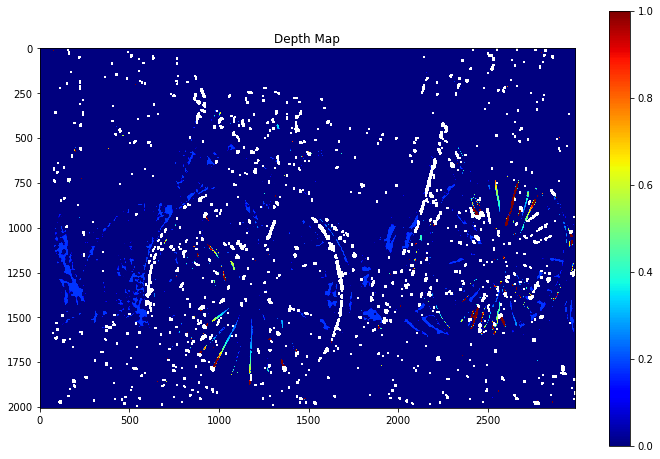

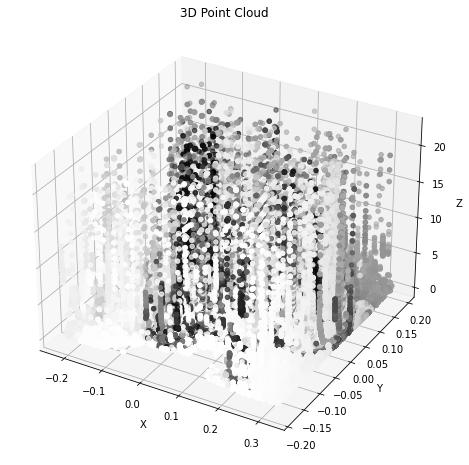

In [1]:
I1 = cv2.imread('./Question 2 and 3 Images/bikeL.png')
I2 = cv2.imread('./Question 2 and 3 Images/bikeR.png')

cam0 = np.array([[5299.313, 0, 1263.818],
                 [0, 5299.313, 977.763],
                 [0, 0, 1]])
cam1 = np.array([[5299.313, 0, 1438.004],
                 [0, 5299.313, 977.763],
                 [0, 0, 1]])
baseline = 177.288

I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2_gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

stereo = cv2.StereoBM_create(numDisparities=64, blockSize=15)
disparity = stereo.compute(I1_gray, I2_gray)

depth_map = baseline / disparity

h, w = I1_gray.shape
focal_length = cam0[0, 0]
cx = cam0[0, 2]
cy = cam0[1, 2]
Y, X = np.mgrid[0:h, 0:w]
X = (X - cx) / focal_length
Y = (Y - cy) / focal_length
Z = baseline / disparity

valid_mask = disparity > 0
X = X[valid_mask]
Y = Y[valid_mask]
Z = Z[valid_mask]

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(I1, cv2.COLOR_BGR2RGB))
plt.title('Left Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(I2, cv2.COLOR_BGR2RGB))
plt.title('Right Image')
plt.show()

plt.figure(figsize=(12, 8))
plt.imshow(disparity, cmap='plasma')
plt.colorbar()
plt.title('Disparity Map')
plt.show()

plt.figure(figsize=(12, 8))
plt.imshow(depth_map, cmap='jet', vmin=0, vmax=1)
plt.colorbar()
plt.title('Depth Map')
plt.show()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, c=I1_gray[valid_mask], cmap='gray')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Point Cloud')

plt.show()


### **3. Epipolar Lines**

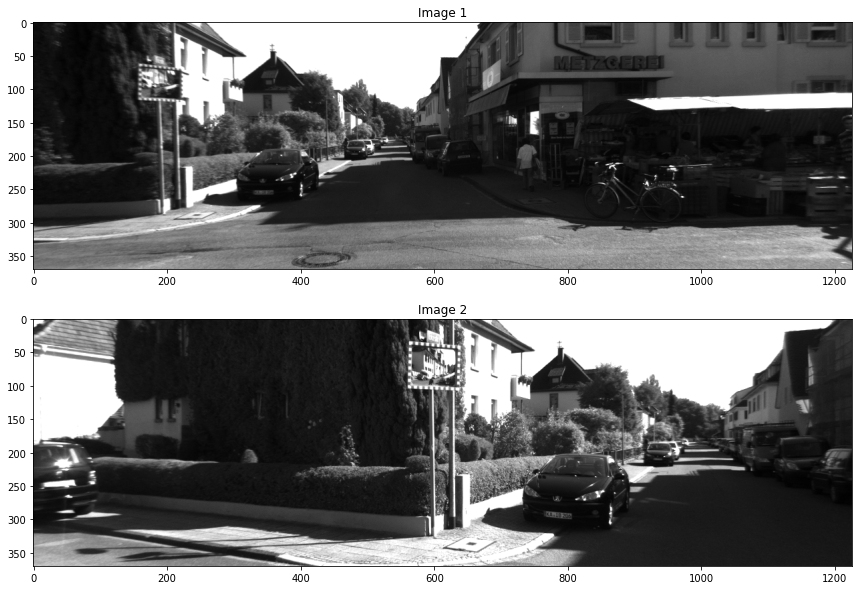

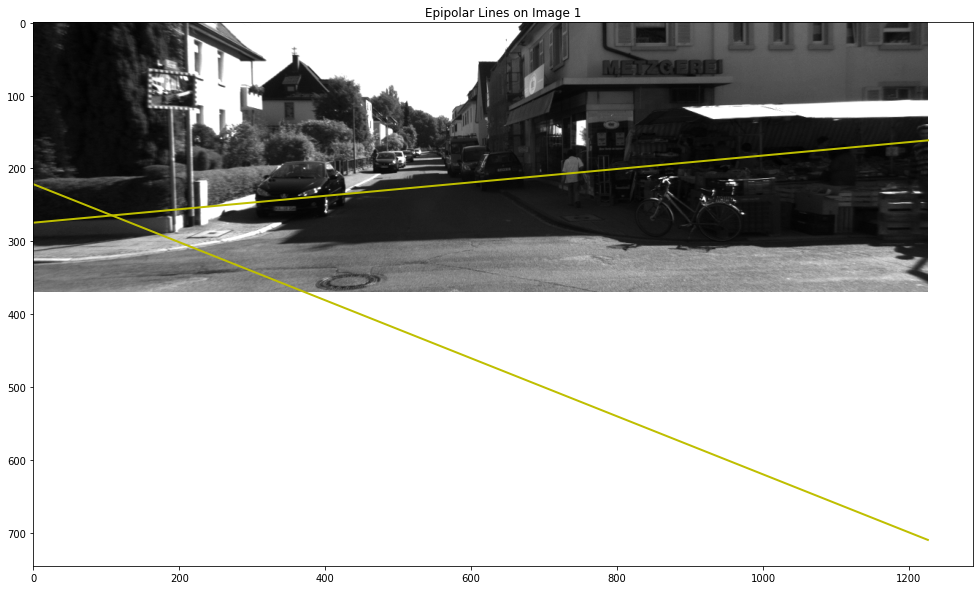

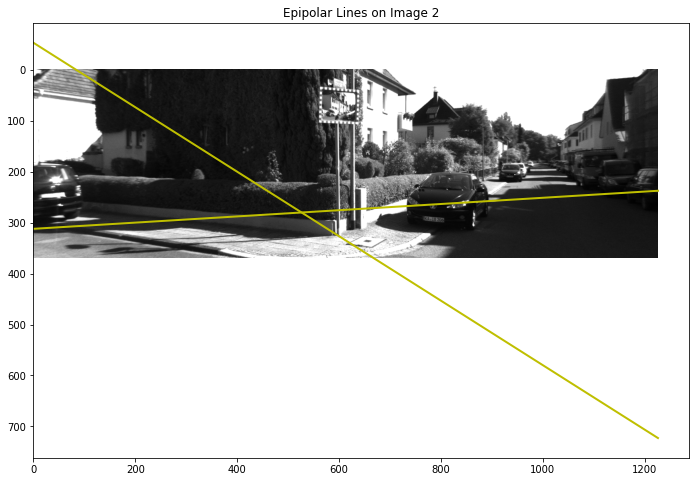

In [2]:
F = np.array([[3.34638533e-07,  7.58547151e-06, -2.04147752e-03],
              [-5.83765868e-06,  1.36498636e-06, 2.67566877e-04],
              [1.45892349e-03, -4.37648316e-03,  1.00000000e+00]])

image1 = cv2.imread("./Question 2 and 3 Images/000000.png", cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread("./Question 2 and 3 Images/000023.png", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(22, 10))
plt.subplot(2, 1, 1)
plt.imshow(image1, cmap='gray')
plt.title('Image 1')
plt.subplot(2, 1, 2)
plt.imshow(image2, cmap='gray')
plt.title('Image 2')
plt.show()

def compute_epipolar_lines(F, points):
    return np.dot(F, points.T).T

points = np.array([[200, 300, 1], [400, 200, 1]])

epipolar_lines = compute_epipolar_lines(F.T, points)

plt.figure(figsize=(22, 10))
plt.imshow(image1, cmap='gray')
for line in epipolar_lines:
    plt.plot([0, image1.shape[1]], [-line[2]/line[1], -(line[0]*image1.shape[1]+line[2])/line[1]], 'y-', linewidth=2)
plt.title('Epipolar Lines on Image 1')
plt.show()

corresponding_points_image2 = np.array([[0, -line[2]/line[1], 1] for line in epipolar_lines])

epipolar_lines_image1 = compute_epipolar_lines(F, corresponding_points_image2)

plt.figure(figsize=(22, 8))
plt.imshow(image2, cmap='gray')
for line in epipolar_lines_image1:
    plt.plot([0, image2.shape[1]], [-line[2]/line[1], -(line[0]*image2.shape[1]+line[2])/line[1]], 'y-', linewidth=2)
plt.title('Epipolar Lines on Image 2')
plt.show()
